In [25]:
from lbmpy.session import *
from lbmpy.parameterization import Scaling

In [26]:
ref_length = 1
inflow_velocity = 1
Re = 400
kinematic_viscosity = ref_length*inflow_velocity/Re
cells_per_length = 20
sc = Scaling(
    physical_length=ref_length,
    physical_velocity=inflow_velocity,
    kinematic_viscosity=kinematic_viscosity,
    cells_per_length=cells_per_length
)
lattice_velocity = 0.05
scaling = sc.fixed_lattice_velocity_scaling(lattice_velocity=lattice_velocity)
relaxation_rate = scaling.relaxation_rate
dt = scaling.dt
scaling

FixedLatticeVelocityScalingResult(relaxation_rate=1.9704433497536948, dt=0.0025000000000000005)

In [27]:
stencil = LBStencil(Stencil.D2Q9)
domain_size = (20*ref_length*cells_per_length, 10*ref_length*cells_per_length)
dim = len(domain_size)

In [28]:
dh = ps.create_data_handling(domain_size=domain_size, periodicity=(False, False))
src = dh.add_array('src', values_per_cell=len(stencil), alignment=True)
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=len(stencil), alignment=True)
dh.fill('dst', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim, alignment=True)
dh.fill('velField', 0.0, ghost_layers=True)

In [29]:
lbm_config = LBMConfig(
    stencil=Stencil.D2Q9,
    method=Method.CUMULANT,
    relaxation_rate=relaxation_rate,
    compressible=True,
    output={'velocity': velField}
)
method = create_lb_method(lbm_config=lbm_config)
method

In [30]:
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments
init = pdf_initialization_assignments(
    lb_method=method,
    density=1.0,
    velocity=(0.0, 0.0),
    pdfs=src.center_vector
)
ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

In [31]:
lbm_optimisation = LBMOptimisation(
    symbolic_field=src,
    symbolic_temporary_field=dst
)
update = create_lb_update_rule(
    lb_method=method,
    lbm_config=lbm_config,
    lbm_optimisation=lbm_optimisation
)
ast_kernel = ps.create_kernel(
    update,
    target=dh.default_target,
    cpu_openmp=True
)
kernel = ast_kernel.compile()

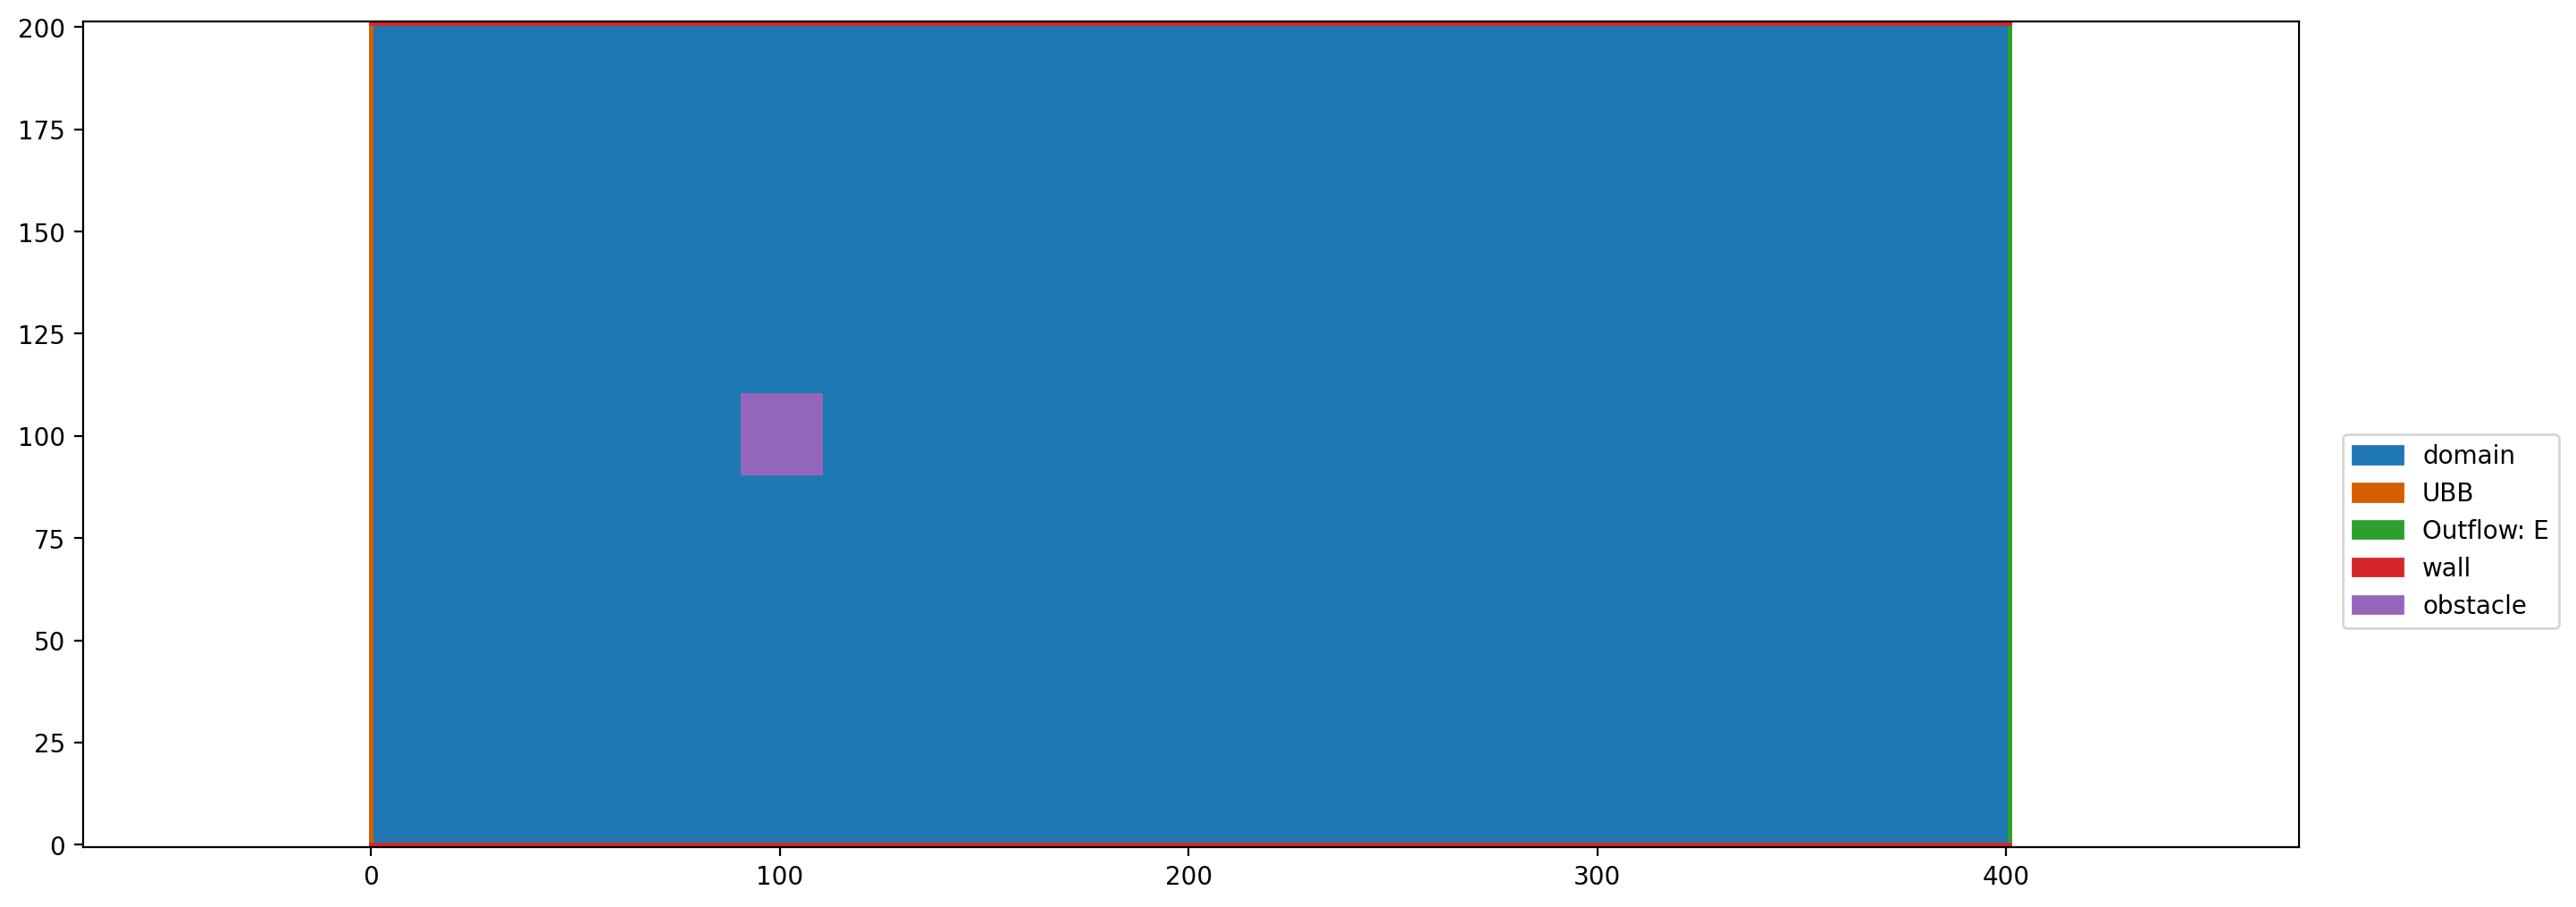

In [32]:
def set_square(x, y, *_):
    center = (domain_size[0]//4, domain_size[1]//2)
    half = ref_length*cells_per_length//2
    return (center[0] - half <= x) & (center[0] + half >= x) & (center[1] - half <= y) & (center[1] + half >= y)
    # return (x - center[0])**2 + (y - center[1])**2 < half**2

bh = LatticeBoltzmannBoundaryHandling(
    lb_method=method,
    data_handling=dh,
    pdf_field_name='src',
    name='bh'
)

inflow = UBB((lattice_velocity, 0))
outflow = ExtrapolationOutflow(stencil[4], method)
wall = FreeSlip(stencil=stencil, name='wall')

bh.set_boundary(inflow, slice_from_direction('W', dim))
bh.set_boundary(outflow, slice_from_direction('E', dim))
for direction in ('N', 'S'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))

bh.set_boundary(NoSlip('obstacle'), mask_callback=set_square)

plt.figure(dpi=200)
plt.boundary_handling(bh)

In [33]:
def time_loop(nstep):
    for i in range(nstep):
        bh()
        dh.run_kernel(kernel)
        dh.swap('src', 'dst')

In [34]:
mask = np.fromfunction(set_square, (domain_size[0], domain_size[1], dim))

In [35]:
nstep = int(200/dt)
print(nstep)
time_loop(nstep)

79999


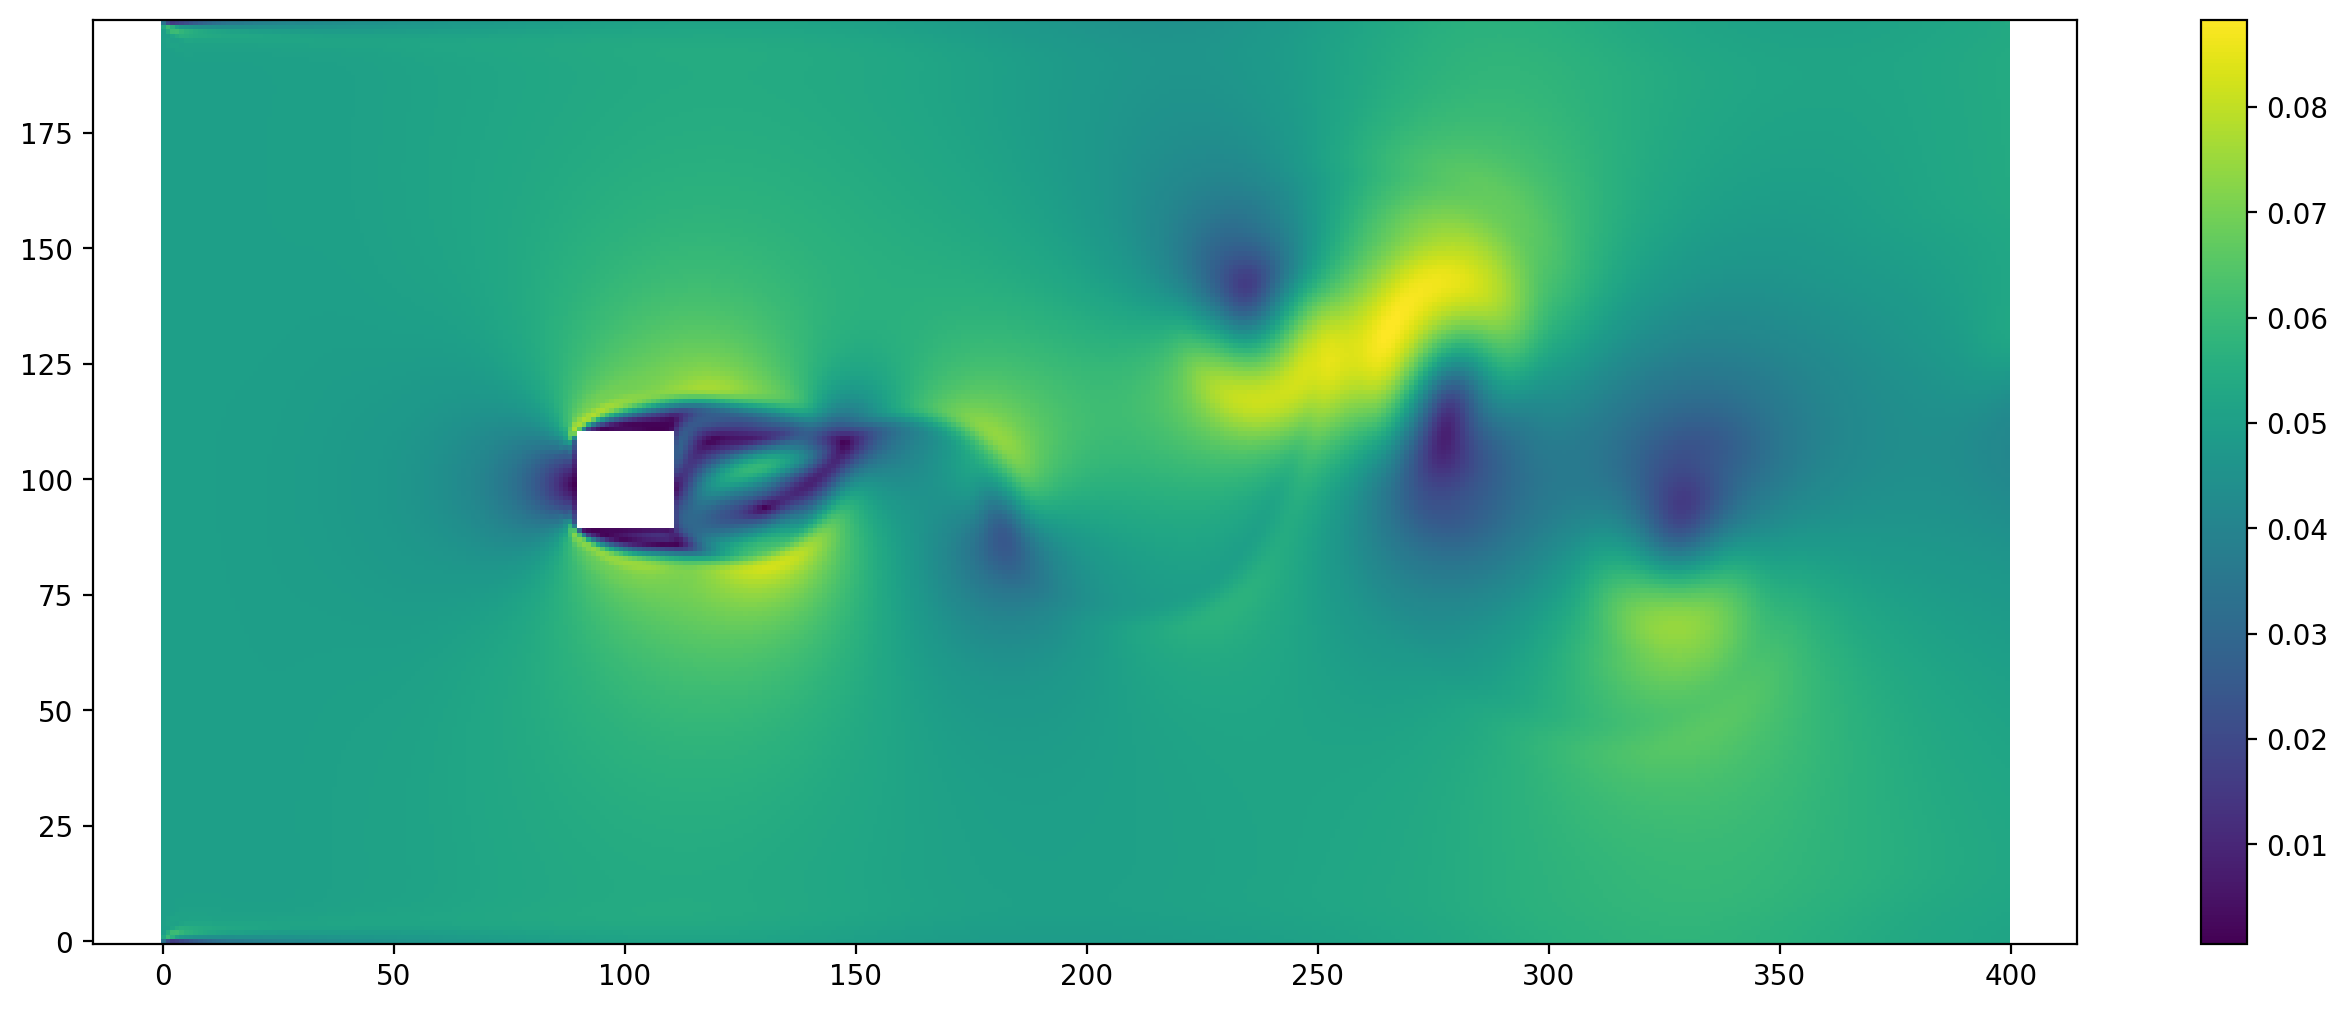

In [36]:
plt.figure(dpi=200)
result = np.ma.array(dh.gather_array('velField'), mask=mask)
plt.vector_field_magnitude(result)
plt.colorbar()

In [37]:
r = dh.gather_array('velField')
r.shape
with open('data/test.csv', "w") as f:
    f.write('x,y,z,u,v,w\n')
    for j in range(r.shape[1]):
        for i in range(r.shape[0]):
            f.write(f'{i/cells_per_length},{j/cells_per_length},{0},{r[i,j,0]},{r[i,j,1]},{0}\n')